<a href="https://colab.research.google.com/github/nimeth02/customer_support_agent/blob/main/customer_support_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langchain_core langchain_groq langchain_community langgraph


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 8.6 MB/s eta 0:00:00


In [ ]:
from typing import TypedDict, Dict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display , Image

In [ ]:
class State(TypedDict):
        query: str
        category: str
        sentiment: str
        response: str

In [ ]:
from google.colab import userdata

# Get the API key
api_key = userdata.get('GROQ_API_KEY')

In [ ]:
from langchain_groq import ChatGroq

llm = ChatGroq(
            temperature=0,
            groq_api_key = api_key,
            model_name = "llama-3.3-70b-versatile"
        )
result = llm.invoke("What is china town")
result.content

"Chinatown is a term used to describe an ethnic enclave of Chinese people living outside of China, typically in a urban area. Chinatowns are usually characterized by a high concentration of Chinese restaurants, shops, cultural institutions, and residents. They often serve as a hub for the local Chinese community, providing a sense of cultural identity and connection to their heritage.\n\nChinatowns can be found in many cities around the world, including:\n\n1. **San Francisco, USA**: One of the largest and oldest Chinatowns in the United States, established in 1848.\n2. **New York City, USA**: Manhattan's Chinatown is one of the largest in the United States, with a population of over 100,000 Chinese Americans.\n3. **London, UK**: London's Chinatown is located in the West End and is one of the largest in Europe.\n4. **Vancouver, Canada**: Vancouver's Chinatown is one of the largest in North America, with a rich history dating back to the late 19th century.\n5. **Singapore**: Singapore h

In [ ]:
# Define the nodes
def categorize(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | llm
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}

def analyze_sentiment(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state["query"]}).content
    return {"sentiment": sentiment}

def handle_technical(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a technical support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_billing(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a billing support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_general(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide a general support response to the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def escalate(state: State) -> State:
    return {"response": "This query has been escalated to a human agent due to its negative sentiment"}

def route_query(state: State) -> str:
    if state["sentiment"] == "Negative":
        return "escalate"
    elif state["category"] == "Technical":
        return "handle_technical"
    elif state["category"] == "Billing":
        return "handle_billing"
    else:
        return "handle_general"

In [ ]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", analyze_sentiment)
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing",
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

# Add edges to end
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

# Set entry point
workflow.set_entry_point("categorize")

# Compile the workflow
app = workflow.compile()

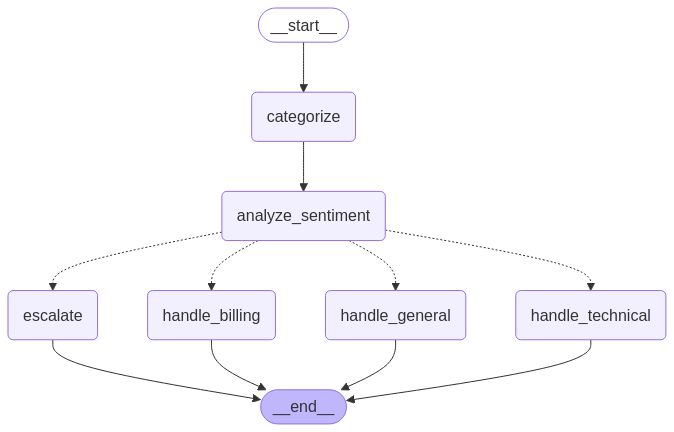

In [ ]:
display(
            Image(
                app.get_graph().draw_mermaid_png(
                    draw_method=MermaidDrawMethod.API
               )
            )
        )

In [ ]:
def run_customer_support(query: str)->Dict[str, str]:
          results = app.invoke({"query": query})
          return {
              "category":results['category'],
              "sentiment":results['sentiment'],
              "response": results['response'],
          }

In [ ]:
query = "My internet connection is gone it's not working, Can you help me?"
result = run_customer_support(query)

print(f"Query: {query}")
print(f"Category: {result['category']}")
print(f"Sentiment: {result['sentiment']}")
print(f"Response: {result['response']}")
print("\n")

Query: My internet connection is gone it's not working, Can you help me?
Category: The customer query can be categorized as: Technical. 

This is because the query is related to a technical issue with the customer's internet connection, and they are seeking assistance to resolve the problem.
Sentiment: Negative.
Response: I'm so sorry to hear that your internet connection is not working. I'd be happy to help you troubleshoot the issue. Can you please try a few things to help me narrow down the problem?

1. **Restart your router**: Sometimes, a simple reboot can resolve the issue. Try unplugging the power cord from your router, waiting for 30 seconds, and then plugging it back in.
2. **Check your cables**: Ensure that all cables are securely connected to your router, modem, and device (computer, laptop, etc.).
3. **Check your internet service provider's status**: It's possible that there's an outage in your area. You can check your ISP's website or social media for any updates on outage